# Model Training

### Import Libraries & Load Metadata

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from tensorflow.keras.utils import to_categorical

In [13]:
meta_path = "../data/cibs-ddsm/metadata/meta.csv"
df = pd.read_csv(meta_path)

### Load Images into Memory

In [14]:
def load_images(df, size=(224, 224)):
    X, y = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["processed_path"], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            X.append(img)
            y.append(row["label"])
    X = np.array(X)[..., np.newaxis] / 255.0  
    y = np.array(y)
    return X, y

### Split dataset

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
X_train, y_train = load_images(train_df)
X_test, y_test = load_images(test_df)

### Build CNN Model with Augmentation

### Batch normalisation 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, RandomFlip,
                                     RandomRotation, RandomZoom)

model = Sequential([
    Input(shape=(224, 224, 1)), 
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [20]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

## Check for label distribution

In [21]:
import pandas as pd
df = pd.read_csv("../data/cibs-ddsm/metadata/labels_resolved.csv")
df["label"].value_counts()

label
0    2111
1    1457
Name: count, dtype: int64

## Calculate Class Weights

In [22]:
from sklearn.utils import class_weight
import numpy as np

# Ensure labels are NumPy arrays
y_train = np.array(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [23]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5140 - loss: 0.9150 - val_accuracy: 0.4641 - val_loss: 0.6931
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.4740 - loss: 0.6900 - val_accuracy: 0.4448 - val_loss: 0.6942
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - accuracy: 0.4762 - loss: 0.6922 - val_accuracy: 0.4203 - val_loss: 0.6942
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.4735 - loss: 0.6899 - val_accuracy: 0.5131 - val_loss: 0.6929
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.4806 - loss: 0.6935 - val_accuracy: 0.5744 - val_loss: 0.6918
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.5417 - loss: 0.6938 - val_accuracy: 0.5902 - val_loss: 0.6911
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.5289 - loss: 0.6929 - val_accuracy: 0.5377 - val_loss: 0.6913
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.5239 - loss: 0.6929 - val_accu

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
model.save("../results/model_weights/final_model.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5781 - loss: 0.6927


Test Accuracy: 0.5756


In [30]:
Path("results/model_weights").mkdir(parents=True, exist_ok=True)
model.save("results/model_weights/final_model.h5")

In [25]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Get predicted probabilities
y_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_probs > 0.5).astype(int)

# 1. Classification report: precision, recall, f1-score, accuracy
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# 2. ROC-AUC score (based on raw probabilities, not thresholded)
auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {auc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
              precision    recall  f1-score   support

      Benign       0.59      0.94      0.72       422
   Malignant       0.37      0.05      0.09       292

    accuracy                           0.58       714
   macro avg       0.48      0.49      0.41       714
weighted avg       0.50      0.58      0.46       714

ROC AUC Score: 0.4749


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
[[396  26]
 [277  15]]
              precision    recall  f1-score   support

           0       0.59      0.94      0.72       422
           1       0.37      0.05      0.09       292

    accuracy                           0.58       714
   macro avg       0.48      0.49      0.41       714
weighted avg       0.50      0.58      0.46       714



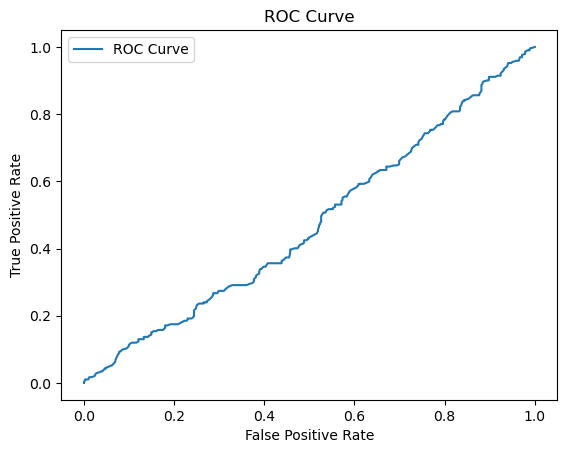

ROC AUC Score: 0.4748709666947997


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))